In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
import sys 
sys.path.append('..')
from utils.dataloader import load_data

pio.templates.default = "plotly_white"

#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)


/opt/homebrew/Caskroom/miniforge/base/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = load_data()

In [4]:
def create_hub_name(station):
   hub_name = station.rsplit('/', 1)[1].lstrip().rsplit(' ', 1)[0]
   if hub_name == 'BRYANT #':
      return 'BRYANT'
   else: 
      return hub_name

def count_plugs(station, station_list, no_plug_list):
   no_plugs = len(df['Port Number'].loc[df['Station Name'] == station].unique())
   return no_plugs
   '''if 'SHERMAN' in station:
      return 2
   else: 
      return no_plugs'''

In [5]:
## Add hub colu,n
df['Hub'] = df['Station Name'].apply(create_hub_name)

In [6]:
port_num = []
station_name = []
j = 0
for i in df['Station Name'].unique():
    station_name.append(i)
    df_port_num = df['Port Number'].loc[df['Station Name'] == i].unique()
    port_num.append(int(len(df_port_num)))

plug_per_station = dict(zip(station_name, port_num))


In [7]:
## Poulate variable no. of plugs with plugs pr. unique station
df['No. Plugs'] = np.zeros(len(df))
for key, value in plug_per_station.items():
    df.loc[df['Station Name'] == key, ['No. Plugs']] = value

<Axes: title={'center': 'Total plugin events pr. hub'}, xlabel='Hub'>

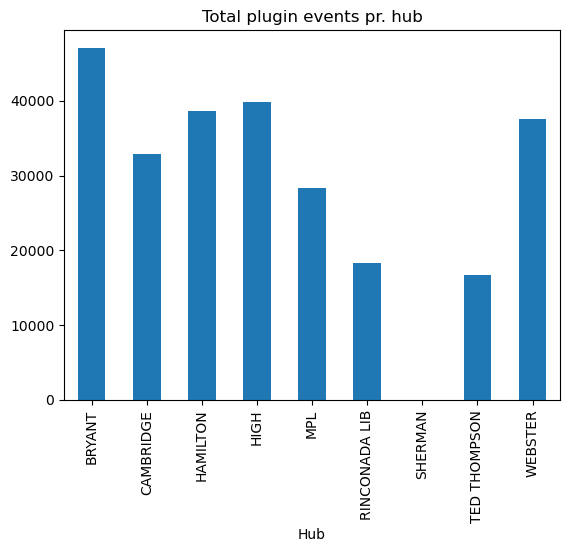

In [8]:
df.groupby('Hub')['Plug In Event Id'].count().plot.bar(title = 'Total plugin events pr. hub')

<Axes: title={'center': 'Total plugs per station'}, xlabel='Station Name'>

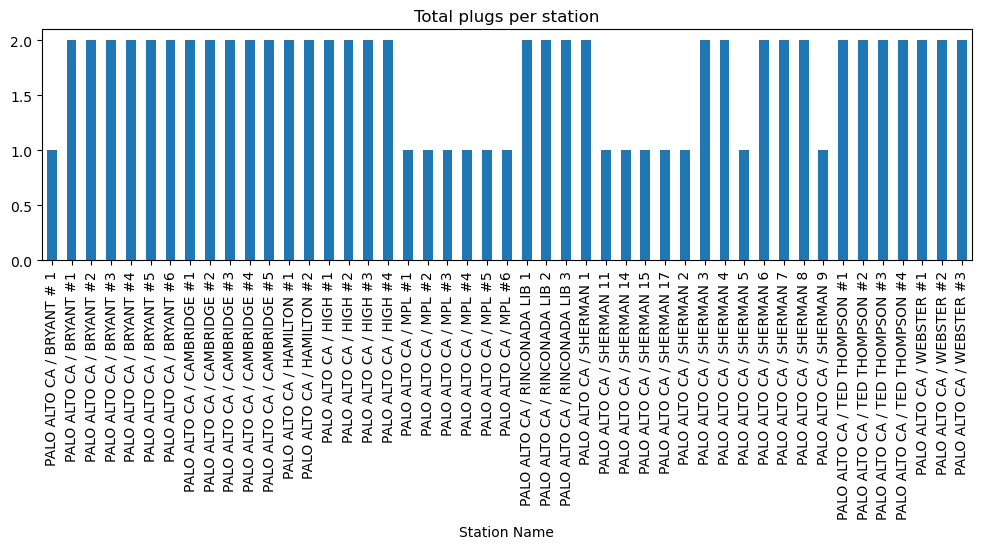

In [9]:
df.groupby('Station Name')['No. Plugs'].first().plot.bar(title = 'Total plugs per station', figsize=(12, 3))

In [10]:
## Find first time a specific plug at a specific station is in use
list_of_first_records = []
for i in df['Station Name'].unique():
    list_of_first_records.append(df[df['Station Name'] == i].iloc[0].values)
df_charging_stations = pd.DataFrame(list_of_first_records)
df_charging_stations = df_charging_stations.set_axis(df.columns.unique().values, axis=1, inplace=False)

In [11]:
## Count no. of charging stations pr. hub over time
df_charging_stations['No. Stations'] = df_charging_stations.groupby('Hub').cumcount()
df_charging_stations['No. Stations'] = df_charging_stations['No. Stations'] + 1
df_charging_stations['No. Plugs per Hub'] = df_charging_stations.groupby('Hub').cumsum()['No. Plugs']
df_charging_stations_per_hub = df_charging_stations[['Station Name', 'Start Date', 'Port Number', 'Hub', 'No. Stations', 'No. Plugs per Hub']]

In [12]:
## Create df with time and hubs as rows and columns respectively. Filled with number of charging stations
df_hub = df_charging_stations_per_hub.pivot_table(values='No. Stations', index=['Start Date'], columns='Hub', aggfunc='first')
df_hub = df_hub.fillna(0)
df_hub = df_hub.replace(to_replace=0, method='ffill')

In [13]:
df_plug_hub = df_charging_stations_per_hub.pivot_table(values='No. Plugs per Hub', index=['Start Date'], columns='Hub', aggfunc='first')
df_plug_hub = df_plug_hub.fillna(0)
df_plug_hub = df_plug_hub.replace(to_replace=0, method='ffill')

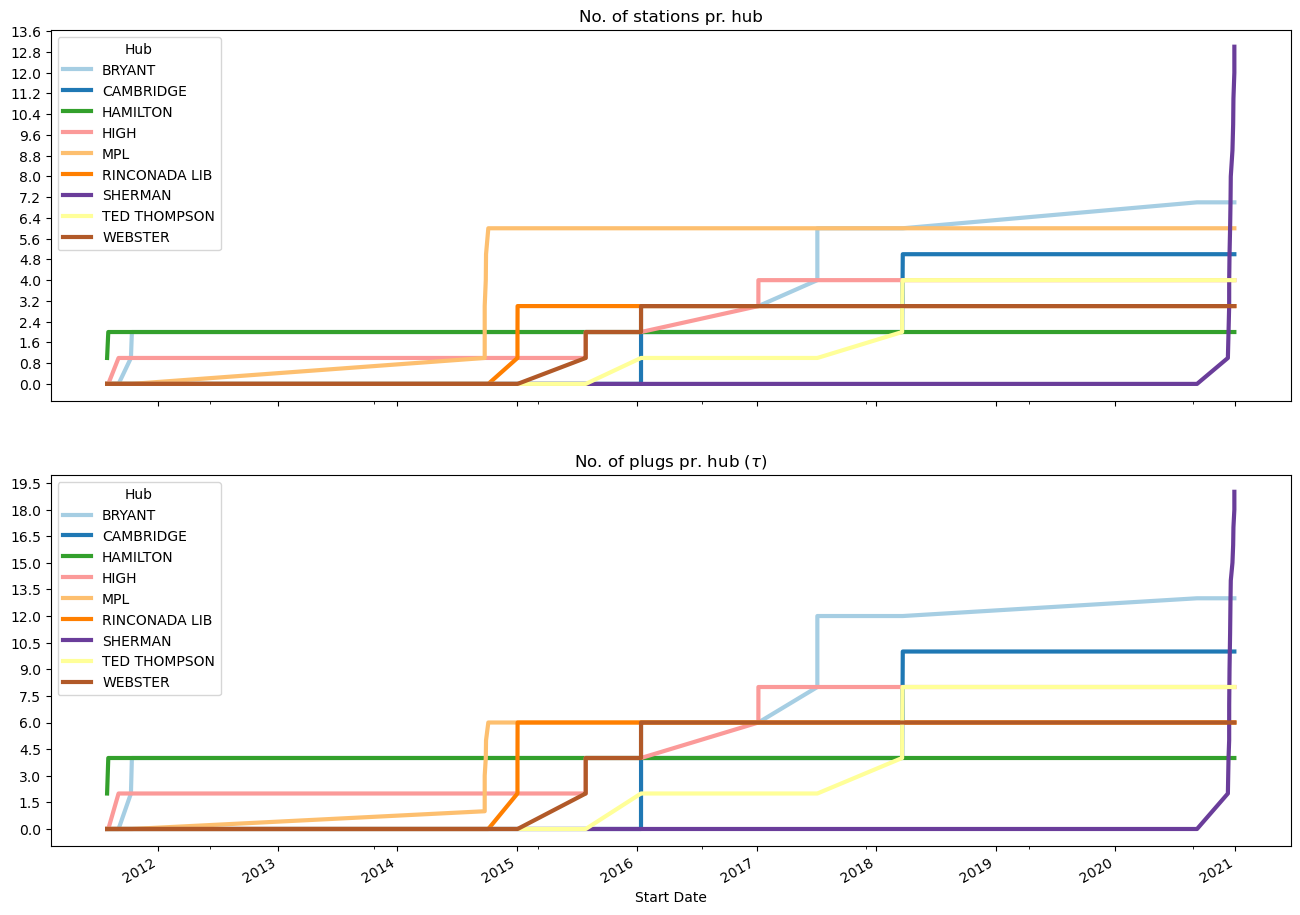

In [14]:
fig, axes = plt.subplots(2, figsize=(16,12), sharex=True)
df_hub.plot(colormap = 'Paired', linewidth = 3, title = 'No. of stations pr. hub', ax=axes[0])
df_plug_hub.plot(colormap = 'Paired', linewidth = 3, title = r'No. of plugs pr. hub ($\tau$)', ax=axes[1])

from matplotlib.ticker import MaxNLocator
axes[0].yaxis.set_major_locator(MaxNLocator(20))
axes[1].yaxis.set_major_locator(MaxNLocator(20))

## Exploring distributions from when the models begin recording

In [23]:
## Read count data format
df_event = pd.read_csv('../Data/charging_session_count_30_viz.csv', index_col=0, parse_dates=['Period'])
#df_event = create_count_data(df, interval_length = 30, save = True)

In [24]:
df_event['Cluster'].unique()[:-1]

array(['HAMILTON', 'HIGH', 'BRYANT', 'MPL', 'RINCONADA', 'WEBSTER', 'TED',
       'CAMBRIDGE'], dtype=object)

In [25]:
## Getting first record of each station 
first_date_rec = []
j = 0

for i in df_charging_stations['Hub'].unique():
    first_recording = df_charging_stations['Start Date'].loc[df_charging_stations['Hub'] == i].iloc[0]
    first_date_rec.append(first_recording)
    

station_name = df_event.columns.values
hub_start_dict = dict(zip(station_name, first_date_rec))


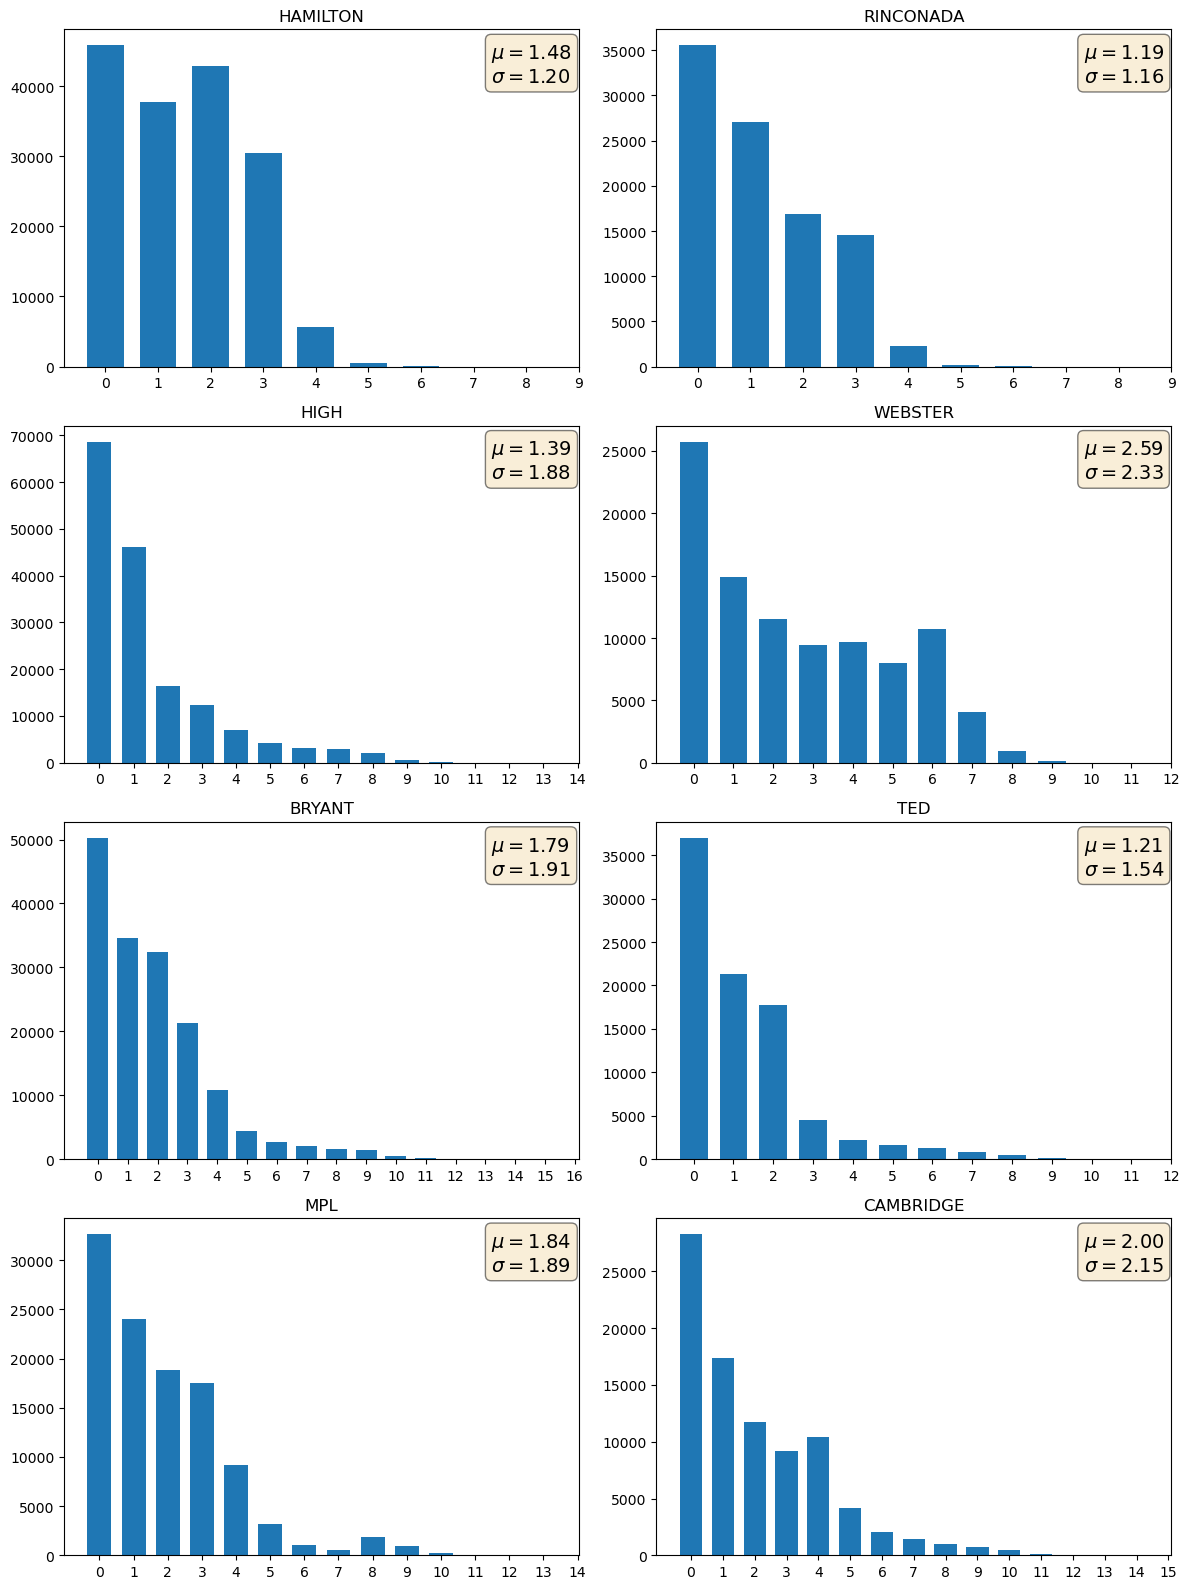

In [26]:
#plot_list = df_event.columns.values
plot_list = df_event['Cluster'].unique()[:-1]
fig, axes = plt.subplots(4,2, figsize=(12, 16))
i = 0
j = 0
for key in plot_list:
    cluster_events = df_event['Sessions'].loc[df_event['Cluster'] == key]
    cluster_mean = np.mean(df_event['Sessions'].loc[df_event['Cluster'] == key])
    cluster_sd = np.std(df_event['Sessions'].loc[df_event['Cluster'] == key])

    #cluster_events = df_event[key].values
    #cluster_mean = np.mean(cluster_events)
    #cluster_sd = np.std(cluster_events)

    axes[i,j].hist(cluster_events, bins = range(int(np.max(cluster_events))+3), rwidth=0.7)
    axes[i,j].set_title(str(key))
    axes[i,j].plot()
    axes[i,j].set_xticks(np.arange(np.max(cluster_events)+3) + 0.5)
    axes[i,j].set_xticklabels(np.arange(np.max(cluster_events)+3))

    textstr = '\n'.join((
    r'$\mu=%.2f$' % (cluster_mean, ),
    r'$\sigma=%.2f$' % (cluster_sd, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[i,j].text(0.83, 0.962, textstr, transform=axes[i,j].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    i += 1
    if i == 4:
        j += 1
        i = 0
fig.tight_layout()
#fig.savefig("Figures/Distributions.png", bbox_inches='tight')


In [27]:
### Could attempt to find best fitted pdf to above distributions

## Daily and weekly patterns 
#### Using quantile plots to explore patterns across clusters

In [28]:
## Add day and hour variable
df_event['Day'] = df_event['Period'].dt.dayofweek
df_event['Hour'] = df_event['Period'].dt.hour

In [29]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [30]:
np.linspace(10, 50,3)[:-1]

array([10., 30.])

In [31]:
np.linspace(50, 90,3)[1:]

array([70., 90.])

In [32]:
def tsplot_v2(df, n=2, time_scale = 24, Cluster = 'HAMILTON', value = 'Sessions', percentile_min=10, percentile_max=90, color='r', plot_mean=False, plot_median=True, line_color='k', ax1 = 0, ax2 = 0, plt_axes = axes, **kwargs):
    x = np.arange(0,time_scale)

    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.zeros((n, time_scale))
    perc2 = np.zeros((n, time_scale))

    if time_scale == 7:
        group_var = 'Day'
    else: 
        group_var = 'Hour'

    label_list = []
    j = 0
    for i in np.linspace(percentile_min, 50, n)[:-1]:
        perc1[j,:] = df[df['Cluster'] == Cluster].groupby(group_var).agg([percentile(i)])[value].values.flatten()
        label_list.append(i)
        j +=1
    
    k = 0
    for i in np.linspace(50, percentile_max, n)[1:]:
        perc2[k,:] = df[df['Cluster'] == Cluster].groupby(group_var).agg([percentile(i)])[value].values.flatten()
        label_list.append(i)
        k +=1

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    # fill lower and upper percentile groups
    p = 0
    for p1, p2 in zip(perc1, perc2):
        if (p == n-1):
            label_name = '_nolegend_'
        else:
            label_name = f'{label_list[p]:.0f}-{100-label_list[p]:.0f}% percentile'
        axes[ax1, ax2].fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None, label = label_name)
        p += 1

    if plot_mean:
        axes[ax1, ax2].plot(x, df[df['Cluster'] == Cluster].groupby(group_var).mean()[value].values, color=line_color, label = 'Mean')

    if plot_median:
        axes[ax1, ax2].plot(x, df[df['Cluster'] == Cluster].groupby(group_var).median()[value].values, color=line_color)

    return

/opt/homebrew/Caskroom/miniforge/base/envs/thesis/lib/python3.10/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_40456/282657294.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


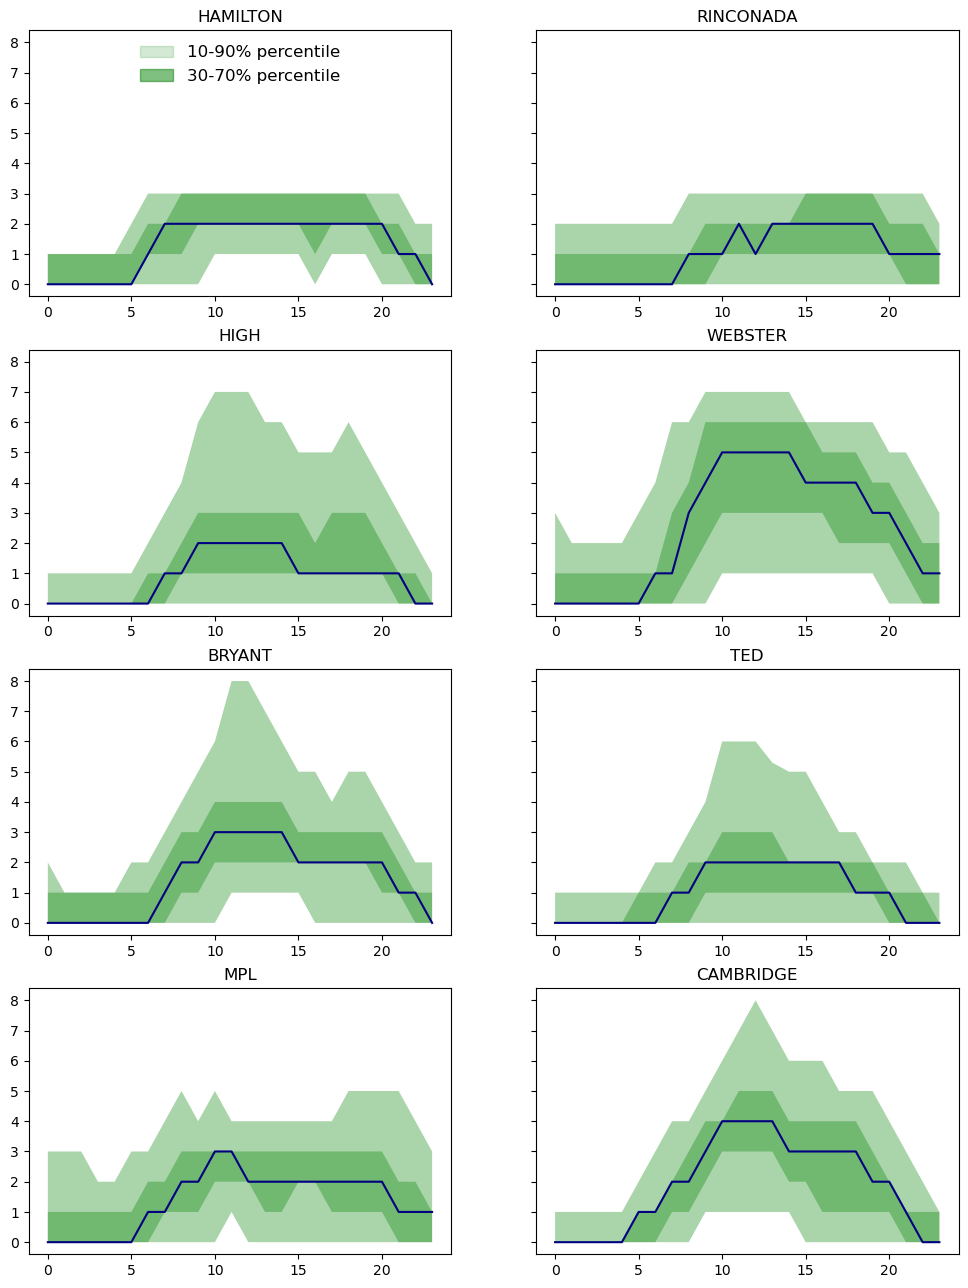

In [33]:
fig, axes = plt.subplots(4,2, figsize=(12, 18), sharey = True)
i = 0
j = 0
n_percentile = 3
for key in plot_list:
    tsplot_v2(df_event, n=n_percentile, time_scale = 24, Cluster = key, value = 'Sessions', percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy', ax1 = i, ax2 = j, plt_axes = axes)
    axes[i,j].set_title(key)
    i += 1
    if i == 4:
        j += 1
        i = 0

legend = axes[0,0].legend(loc="upper center", fontsize=12, markerscale=2, frameon=False)
handles = legend.legendHandles

# There are many more hatches available in matplotlib
for i, handle in (enumerate(handles)):
    handle.set_alpha((i+0.5)*(1/n_percentile))
    handle.set_color('green')

fig.subplots_adjust(bottom=0.2)

#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#axes[i,j].text(0.5, 0.5, textstr, transform=axes[i,j].transAxes, fontsize=14, verticalalignment='top', bbox=props)


### On consumption

In [34]:
df_consum = df[['Start Date', 'Cluster', 'Energy (kWh)']]
df_consum['Day'] = df_consum['Start Date'].dt.dayofweek
df_consum['Hour'] = df_consum['Start Date'].dt.hour

/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_40456/116872807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consum['Day'] = df_consum['Start Date'].dt.dayofweek
/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_40456/116872807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consum['Hour'] = df_consum['Start Date'].dt.hour


/opt/homebrew/Caskroom/miniforge/base/envs/thesis/lib/python3.10/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_40456/746876373.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


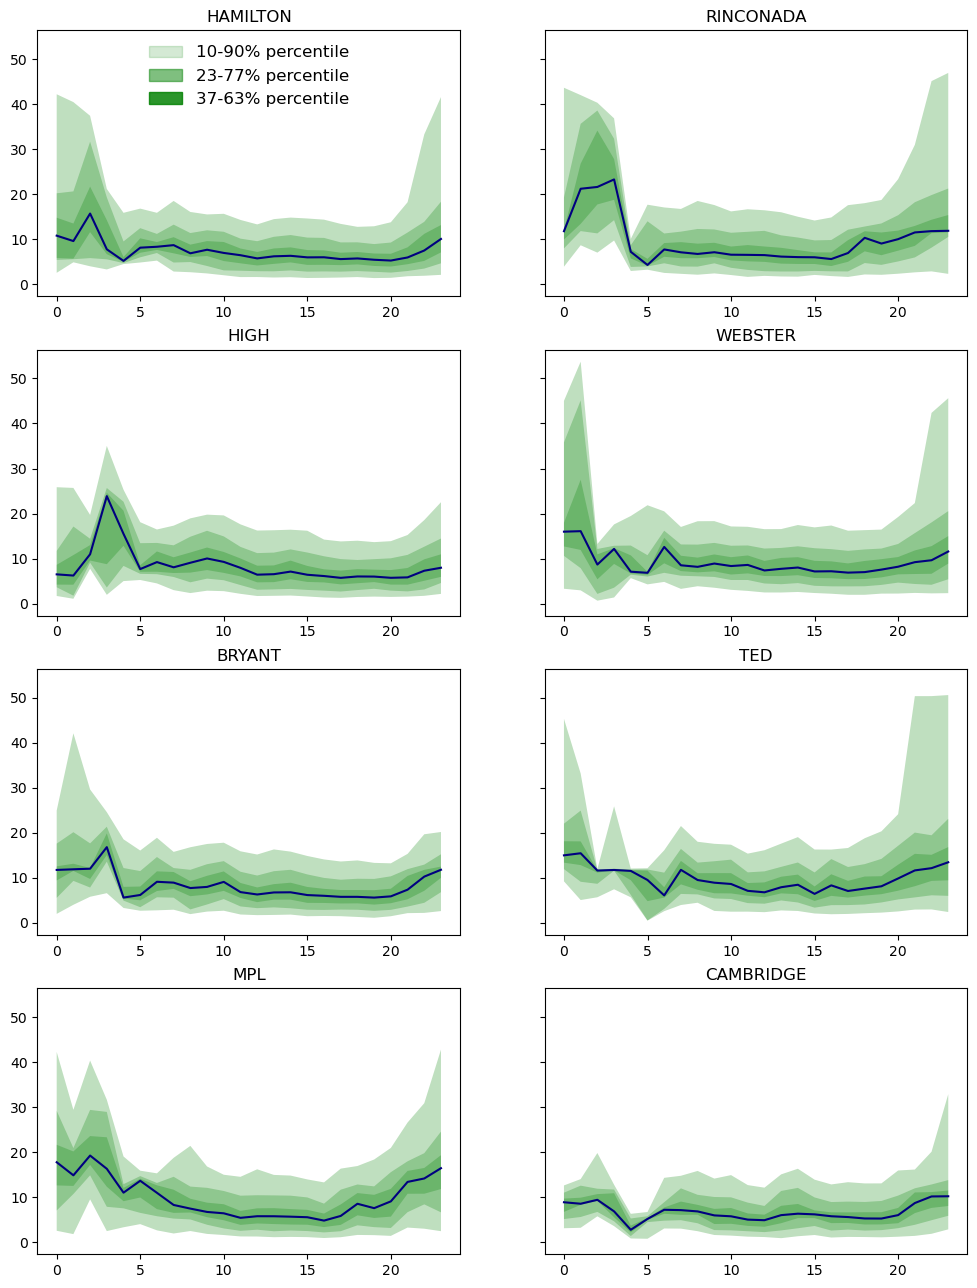

In [36]:
fig, axes = plt.subplots(4,2, figsize=(12, 18), sharey = True)
i = 0
j = 0

for key in plot_list:
    tsplot_v2(df_consum, n=4, time_scale = 24, Cluster = key, value = 'Energy (kWh)', percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy', ax1 = i, ax2 = j, plt_axes = axes)
    axes[i,j].set_title(key)
    i += 1
    if i == 4:
        j += 1
        i = 0

legend = axes[0,0].legend(loc="upper center", fontsize=12, markerscale=2, frameon=False)
handles = legend.legendHandles

# There are many more hatches available in matplotlib
for i, handle in (enumerate(handles)):
    handle.set_alpha((i+0.5)*(1/n_percentile))
    handle.set_color('green')

fig.subplots_adjust(bottom=0.2)
fig.savefig('../Figures/ConsumptionPercentiles.png')

### Weekly patterns

In [37]:
from numpy.random import default_rng
rng = default_rng()

In [38]:
df_weekly = df_event.groupby(['Cluster','Day']).median()['Sessions']
df_weekly_jittered = df_weekly + 0.05*rng.standard_normal(df_weekly.shape)

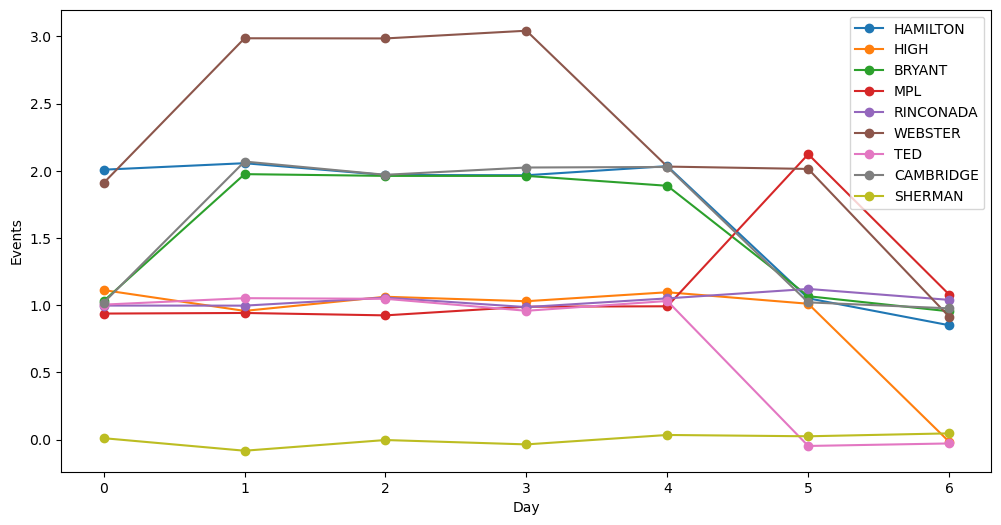

In [39]:
fig, axes = plt.subplots(figsize=(12,6))
for key in df_event['Cluster'].unique():
    axes.plot(df_weekly_jittered[key], '-o', label = key)
    axes.set_xlabel('Day')
    axes.set_ylabel('Events')
    axes.legend()
plt.show()

## Adding max no. plugs for each cluster at any time point

In [40]:
## Create start and end date from plugs table
## Uncomment below if name change is necessary
#df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'EndDate': 'EndDate', 'StartDate': 'StartDate'})
df_charging_stations_per_hub['EndDate'] = df_charging_stations_per_hub['StartDate'].shift(-1, fill_value= df_event['Period'].iloc[-1])
df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'Hub': 'Cluster'})

KeyError: 'StartDate'

In [41]:
## Merge dataframes containing events and the total number of plugs per cluster over time
df_censored = pd.merge(df_event, df_charging_stations_per_hub, how='inner', left_on='Cluster', right_on='Cluster')
df_censored = df_censored[(df_censored['Period']>=df_censored['StartDate']) & (df_censored['Period']<=df_censored['EndDate'])]
df_censored = df_censored[['Period', 'Sessions', 'Cluster', 'Day', 'Hour', 'No. Plugs per Hub']]
df_censored = df_censored.rename(columns =  {'No. Plugs per Hub': 'PlugCap'})

KeyError: 'Cluster'

In [42]:
## Cap no. of observed sessions if they exceed the total number of plugs
df_censored['Sessions'][df_censored['Sessions'] > df_censored['PlugCap']] = df_censored['PlugCap']

NameError: name 'df_censored' is not defined